# Car Detection Dataset



### Data Ref: https://public.roboflow.com/object-detection/vehicles-openimages/

In [1]:
%%capture

!pip3 install numpy==1.17.4

import numpy as np
import pandas as pd 
from tqdm import tqdm

from matplotlib import image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import cv2

!pip install fastai --upgrade

import torch 
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

from fastai.vision.all import *

In [3]:
!cat ./README.dataset.txt

# Vehicles-OpenImages > 416x416
https://public.roboflow.ai/object-detection/vehicles-openimages

Provided by [Jacob Solawetz](https://roboflow.ai)
License: CC BY 4.0

![Image example](https://i.imgur.com/ztezlER.png)

# Overview 

This dataset contains 627 images of various vehicle classes for object detection. These images are derived from the [Open Images](https://arxiv.org/pdf/1811.00982.pdf) open source computer vision datasets.

This dataset only scratches the surface of the Open Images dataset for vehicles!

![Image example](https://i.imgur.com/4ZHN8kk.png)

# Use Cases

* Train object detector to differentiate between a car, bus, motorcycle, ambulance, and truck.
* Checkpoint object detector for autonomous vehicle detector
* Test object detector on high density of ambulances in vehicles
* Train ambulance detector
* Explore the quality and range of Open Image dataset

# Tools Used to Derive Dataset

![Image example](https://i.imgur.com/1U0M573.png)

These images were gathered via

In [4]:
!cat ./README.roboflow.txt


Vehicles-OpenImages - v1 416x416

This dataset was exported via roboflow.ai on June 18, 2021 at 9:03 AM GMT

It includes 627 images.
Vehicles are annotated in COCO format.

The following pre-processing was applied to each image:
* Auto-orientation of pixel data (with EXIF-orientation stripping)
* Resize to 416x416 (Stretch)

No image augmentation techniques were applied.




uint8
(416, 416, 3)


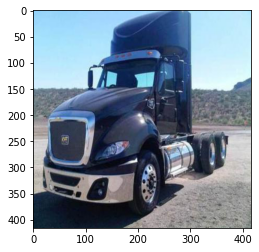

In [5]:
plt_image = image.imread('./train/00aaf0a0a9ee7e71_jpg.rf.808b1e59067887493dffad63561c2a9d.jpg')

print(plt_image.dtype)
print(plt_image.shape)

fig, ax = plt.subplots()

ax.imshow(plt_image)

plt.show()

uint8
(416, 416, 3)


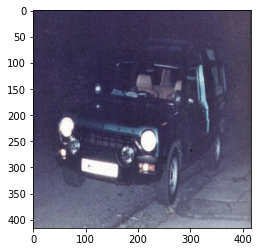

In [6]:
plt_image = image.imread('./train/005980b3a5f93085_jpg.rf.68f1ed44dbca53b707a1d3d82d4b7d9a.jpg')

print(plt_image.dtype)
print(plt_image.shape)

fig, ax = plt.subplots()

ax.imshow(plt_image)

plt.show()

The following is used to find the annotation file in the folder by listing all format contents of the folder

In [7]:
!find ./train -type f | perl -ne 'print $1 if m/\.([^.\/]+)$/' | sort -u

jpg
json


In [8]:
!ls -R |grep "\.json$"

_annotations.coco.json
_annotations.coco.json
_annotations.coco.json


In [9]:
import json

with open('./train/_annotations.coco.json',) as f:
    annotations = json.load(f)

Dataloader with data augmentation

In [10]:
def get_train_transform():
    return A.Compose(
        [
            #A.RandomSizedCrop(min_max_height=(256, 256), height=1024, width=1024, p=0.5),
            #A.OneOf([
            #    A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
            #                         val_shift_limit=0.2, p=0.9),
            #    A.RandomBrightnessContrast(brightness_limit=0.2, 
            #                               contrast_limit=0.2, p=0.9),
            #],p=0.9),
            A.ToGray(p=0.01),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            # A.Resize(height=512, width=512, p=1),
            #A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
            ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [11]:
class CarDetectionDataset(torch.utils.data.Dataset):  
    def __init__(self, images_path, std=False):
        super(CarDetectionDataset, self).__init__()
        self.images_path = glob.glob(images_path+"*jpg")
        self.std = std
        with open(images_path+'_annotations.coco.json',) as f:
            self.annotations = json.load(f)
        
    def __len__(self):
        return len(self.images_path)  

    def __getitem__(self, idx):
        file_path = self.images_path[idx]
        file_name = file_path.split("/")[2]
        img_id = None
        for img_name in self.annotations['images']:
            if img_name['file_name'] == file_name:
                img_id = img_name['id'] 
        
        bbox, areas, iscrowd, labels = [], [], [], []
        
        for box in self.annotations['annotations']:
            if box['image_id'] == img_id:
                bbox.append(box['bbox'])
                areas.append(box['area'])
                iscrowd.append(box['iscrowd'])
                labels.append(box['category_id'])
            
        img = cv2.imread(str(file_path), cv2.IMREAD_UNCHANGED)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        bbox = np.array(bbox)
        areas = np.array(areas)
        iscrowd = np.array(iscrowd)
        labels = np.array(labels)        
        
        bbox[:, 2] = bbox[:, 0] + bbox[:, 2]
        bbox[:, 3] = bbox[:, 1] + bbox[:, 3]
        
        bbox = torch.from_numpy(bbox) 
        bbox = torch.as_tensor(bbox, dtype=torch.int64)
        
        if self.std:
            img = img/255.0
            
        target = {}
        
        labels = torch.tensor(labels, dtype=torch.int64)
        iscrowd = torch.tensor(iscrowd, dtype=torch.int64) 
        image_id = torch.tensor([idx])
        areas = torch.as_tensor(areas.astype(np.float), dtype=torch.double)
        
        target["boxes"] = bbox
        target["labels"] = labels
        target["area"] = areas
        target["iscrowd"] = iscrowd
        target["image_id"] = image_id    
        
        img = np.array(img)
        if img.shape[0] != 3:
            img = img.reshape(3, img.shape[0], img.shape[1])
            
        img = torch.from_numpy(img)
        img = torch.as_tensor(img, dtype=torch.double)
        
        return img, target

The following dictionary maps the labels of thier ids

In [12]:
category_dict = {}
for cat in annotations['categories']:
    category_dict[cat['id']] = cat['name']
category_dict

{0: 'vehicles',
 1: 'Ambulance',
 2: 'Bus',
 3: 'Car',
 4: 'Motorcycle',
 5: 'Truck'}

torch.Size([416, 416, 3]) tensor([[  0,  90, 149, 215],
        [ 40,  97, 395, 301],
        [394, 196, 416, 276]]) tensor([3, 3, 3])


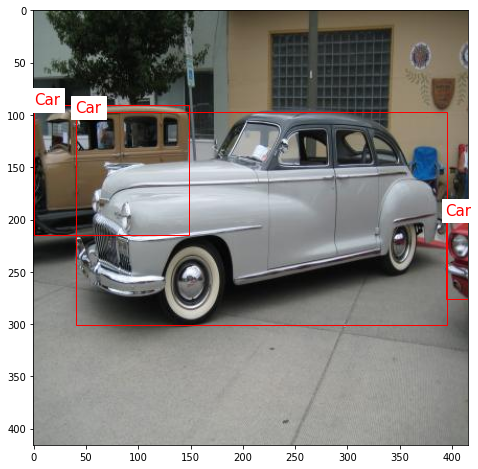

In [13]:
dataset = CarDetectionDataset("./train/")

img, target = dataset.__getitem__(300)

img = img.reshape(img.shape[1], img.shape[2], 3)
img = torch.as_tensor(img, dtype=torch.int)
print(img.shape, target["boxes"], target["labels"])

fig, ax = plt.subplots(figsize=(16,8))
ax.imshow(img)
for lab in target['boxes']:
    rect = patches.Rectangle((lab[0], lab[1]), lab[2]-lab[0], lab[3]-lab[1], 
                             linewidth=1, edgecolor='r', facecolor='none')
    ax.annotate(category_dict[int(target["labels"][0])],(lab[0], lab[1]), 
                color='red', fontsize=15,backgroundcolor="w")

    ax.add_patch(rect)

plt.show()

In [14]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = CarDetectionDataset("./train/", std=True)
val_dataset = CarDetectionDataset("./valid/", std=True)
test_dataset = CarDetectionDataset("./test/", std=True)

train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=4, shuffle=True, num_workers=0,
        collate_fn = collate_fn)

val_dataloader = torch.utils.data.DataLoader(
        val_dataset, batch_size=1, shuffle=False, num_workers=0,
        collate_fn = collate_fn)

test_dataloader = torch.utils.data.DataLoader(
        test_dataset, batch_size=1, shuffle=False, num_workers=0,
        collate_fn = collate_fn)

In [15]:
print('Size of train data: ',len(train_dataset))
print('Size of val data: ',len(val_dataset))
print('Size of test data: ',len(test_dataset))

Size of train data:  878
Size of val data:  250
Size of test data:  126


In [16]:
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print("Device:", device, torch.cuda.get_device_name(0))
else:
    device= torch.device("cpu")
    print("Device:", device)

Device: cuda Tesla P100-PCIE-16GB


The following scripts and libraries are used as a helper functions used for training and validation

In [17]:
%%sh
if [ ! -d "output/vision" ]; then
    git clone https://github.com/pytorch/vision.git output/vision
else
    echo "output/vision already cloned"
fi

cp output/vision/references/detection/utils.py .
cp output/vision/references/detection/transforms.py .
cp output/vision/references/detection/coco_eval.py .
cp output/vision/references/detection/engine.py .
cp output/vision/references/detection/coco_utils.py .

!pip3 install pycocotools
!pip3 install -U scikit-image
!pip3 install -U cython 

Cloning into 'output/vision'...


Here we start build the model with 7 classes (6 classes + background)

In [24]:
import torchvision
num_classes = 7  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
fasterRCNN_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = fasterRCNN_model.roi_heads.box_predictor.cls_score.in_features
fasterRCNN_model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=num_classes)

In [20]:
class LossAverager:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [25]:
from engine import train_one_epoch, evaluate
import time

loss_hist = LossAverager()

EPOCHS = 3

fasterRCNN_model.double()
fasterRCNN_model.to(device)

params = [p for p in fasterRCNN_model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.00005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)


for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    tick = time.time()
    fasterRCNN_model.train()
    loss_hist.reset()
    
    for images, targets in tqdm(train_dataloader):
        
        images = torch.stack(images).to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        bs = images.shape[0]    
        loss_dict = fasterRCNN_model(images, targets)
    
        totalLoss = sum(loss for loss in loss_dict.values())
        lossValue = totalLoss.item()
        loss_hist.update(lossValue, bs)

        optimizer.zero_grad()
        totalLoss.backward()
        optimizer.step()
        lr_scheduler.step(totalLoss)
        
    print(f"Train loss: {loss_hist.avg}")
    
    loss_hist.reset()
    
    for images, targets in val_dataloader:
        images = torch.stack(images).to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = fasterRCNN_model(images, targets)
        totalLoss = sum(loss for loss in loss_dict.values())
        lossValue = totalLoss.item()
        loss_hist.update(lossValue,bs)
        
    print(f"Val loss: {loss_hist.avg}")
    
    fasterRCNN_model.eval()
    evaluate(fasterRCNN_model, val_dataloader, device=device)

Epoch 1/3


100%|██████████| 220/220 [05:50<00:00,  1.59s/it]


Train loss: 0.40670260860895435
Val loss: 0.397495909765645
creating index...
index created!
Test:  [  0/250]  eta: 0:00:38  model_time: 0.1441 (0.1441)  evaluator_time: 0.0047 (0.0047)  time: 0.1533  data: 0.0032  max mem: 13754
Test:  [100/250]  eta: 0:00:23  model_time: 0.1447 (0.1448)  evaluator_time: 0.0027 (0.0037)  time: 0.1543  data: 0.0045  max mem: 13754
Test:  [200/250]  eta: 0:00:07  model_time: 0.1442 (0.1447)  evaluator_time: 0.0025 (0.0037)  time: 0.1526  data: 0.0038  max mem: 13754
Test:  [249/250]  eta: 0:00:00  model_time: 0.1444 (0.1447)  evaluator_time: 0.0027 (0.0036)  time: 0.1538  data: 0.0043  max mem: 13754
Test: Total time: 0:00:38 (0.1535 s / it)
Averaged stats: model_time: 0.1444 (0.1447)  evaluator_time: 0.0027 (0.0036)
Accumulating evaluation results...
DONE (t=0.24s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.018
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.060
 Average Pre

100%|██████████| 220/220 [05:50<00:00,  1.59s/it]


Train loss: 0.36867352989307756
Val loss: 0.41433908075990133
creating index...
index created!
Test:  [  0/250]  eta: 0:00:39  model_time: 0.1451 (0.1451)  evaluator_time: 0.0090 (0.0090)  time: 0.1588  data: 0.0035  max mem: 14523
Test:  [100/250]  eta: 0:00:23  model_time: 0.1455 (0.1453)  evaluator_time: 0.0028 (0.0058)  time: 0.1561  data: 0.0047  max mem: 14523
Test:  [200/250]  eta: 0:00:07  model_time: 0.1444 (0.1455)  evaluator_time: 0.0026 (0.0069)  time: 0.1548  data: 0.0040  max mem: 14523
Test:  [249/250]  eta: 0:00:00  model_time: 0.1447 (0.1454)  evaluator_time: 0.0028 (0.0064)  time: 0.1552  data: 0.0042  max mem: 14523
Test: Total time: 0:00:39 (0.1573 s / it)
Averaged stats: model_time: 0.1447 (0.1454)  evaluator_time: 0.0028 (0.0064)
Accumulating evaluation results...
DONE (t=0.28s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.030
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.082
 Average P

100%|██████████| 220/220 [05:50<00:00,  1.59s/it]


Train loss: 0.36334928554101453
Val loss: 0.416365509258851
creating index...
index created!
Test:  [  0/250]  eta: 0:00:38  model_time: 0.1453 (0.1453)  evaluator_time: 0.0055 (0.0055)  time: 0.1554  data: 0.0034  max mem: 14523
Test:  [100/250]  eta: 0:00:23  model_time: 0.1449 (0.1452)  evaluator_time: 0.0026 (0.0036)  time: 0.1547  data: 0.0046  max mem: 14523
Test:  [200/250]  eta: 0:00:07  model_time: 0.1446 (0.1452)  evaluator_time: 0.0028 (0.0037)  time: 0.1533  data: 0.0040  max mem: 14523
Test:  [249/250]  eta: 0:00:00  model_time: 0.1447 (0.1452)  evaluator_time: 0.0025 (0.0035)  time: 0.1538  data: 0.0043  max mem: 14523
Test: Total time: 0:00:38 (0.1542 s / it)
Averaged stats: model_time: 0.1447 (0.1452)  evaluator_time: 0.0025 (0.0035)
Accumulating evaluation results...
DONE (t=0.21s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.030
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.101
 Average Pre

The model shows poor results. Here we visualize one sample image with predictions

In [29]:
def sample_prediction():
    fasterRCNN_model.eval()
    cpu = torch.device("cpu")
    fasterRCNN_model.to(cpu)
    sample_image = test_dataset.__getitem__(1)[0]
    groundtruth_boxes = test_dataset.__getitem__(1)[1]["boxes"]
    sample_image = torch.unsqueeze(sample_image, 0)
    sample_image.to(cpu)
    outputs = fasterRCNN_model(sample_image)
    outputs = [{k: v for k, v in t.items()} for t in outputs]
    boxes = outputs[0]["boxes"].detach().numpy()
    scores = outputs[0]["scores"].detach().numpy()
    labels = outputs[0]["labels"].detach().numpy()
    sample_image = sample_image.reshape(sample_image.shape[2],sample_image.shape[3], 3)
    return sample_image, boxes, labels, scores, groundtruth_boxes

sample_image, boxes, labels, scores, groundtruth_boxes = sample_prediction()

Here we apply Non Maximum Suppression on the predictions. NMS iteratively removes lower scoring boxes which have an IoU 
greater than iou_threshold with another (higher scoring) box.

In [30]:
def nms():
    iou = 0.99
    iou_threshold = 1 - iou
    NMS = torchvision.ops.nms(torch.tensor(boxes), torch.tensor(scores), iou_threshold)
    best_boxes, best_scores, best_labels = [], [], []
    for nms in NMS:
        best_boxes.append(boxes[nms])
        best_scores.append(scores[nms])
        best_labels.append(labels[nms])
    return best_boxes, best_scores, best_labels

best_boxes, best_scores, best_labels = nms()

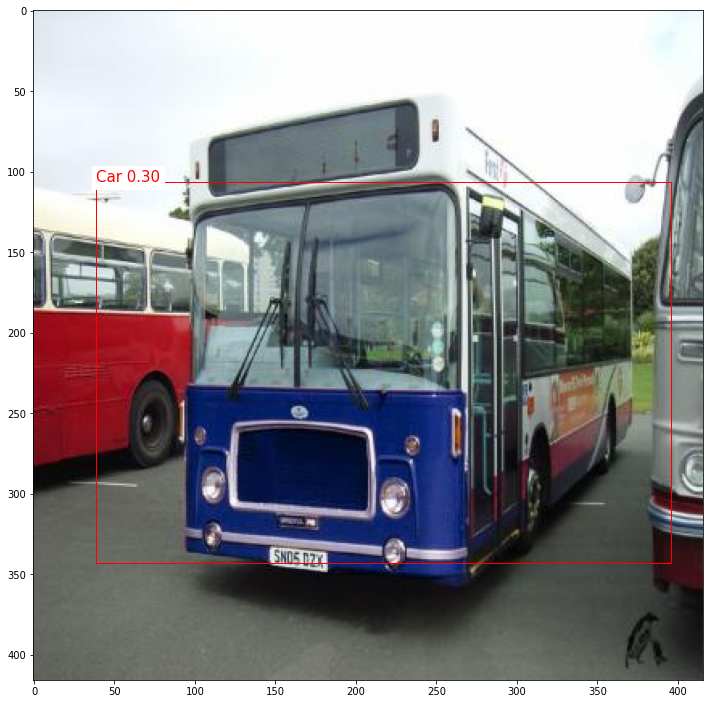

In [31]:
fig, ax = plt.subplots(figsize=(12,18))
ax.imshow(sample_image)
for box, score, label in zip(best_boxes, best_scores, best_labels):
    rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], 
                             linewidth=1, edgecolor='r', facecolor='none')
    ann_text = category_dict[int(label)]+" "+str(score)[:4]
    ax.annotate(ann_text,(box[0], box[1]), color='red', fontsize=15,backgroundcolor="w")
    ax.add_patch(rect)
plt.show()